# Machine Learning for processing XRF maps

## Contents <a id='link0'></a>

### <a href='#link0.0'> **0.0 Introduction** </a>
<a href='#link0.1'> **0.1 Software and packages** </a>

<a href='#link0.2'> **0.2 Functions** </a>

<a href='#link0.3'> **0.3 File Paths** </a>


### <a href='#link1.0'> **1.0 Data Preprocessing**</a>

<a href='#link1.1'> **1.1 Loading Data** </a>

<a href='#link1.2'> **1.2 Extracting analysis run data** </a>

<a href='#link1.3'> **1.3 Extracting and scaling XRF data** </a>

<a href='#link1.4'> **1.4 Slicing signal to scanned energies** </a>

<a href='#link1.5'> **1.5 Saving processed XRF data** </a>

### <a href='#link2.0'> **2.0 Region of Interest Selection** </a>
<a href='#link2.1'> **2.1 Dimension reduction** </a>

<a href='#link2.2'> **2.2 Clustering** </a>

<a href='#link2.3'> **2.3 Regoin XRF spectra output** </a>

### <a href='#link3.0'> **3.0 Quantification** </a>
<a href='#link3.1'> **3.1 Calibration curve** </a>

<a href='#link3.2'> **3.2 External Standards** </a>

<a href='#link3.3'> **3.3 Sample Quantification** </a>

### <a href='#link3.0'> **4.0 Output** </a>

# Introduction <a id='link0.0'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link1.0'> **Next Section**</a>



## 0.1 software, packages and functions <a id='link0.1'></a>

python version... 3.whatever

following are packages used...

In [2]:
#%matplotlib inline

# handling XRF HDF5 data
import h5py 
import hyperspy.api as hs

#handling data
import pandas as pd
import numpy as np

# data vis
import matplotlib.pyplot as plt
import seaborn as sns

#import glob
#import scipy

# data processing, dimension reduction and clustering
import sklearn as skl
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, FactorAnalysis

from skcmeans.algorithms import Probabilistic
from skcmeans.algorithms import Probabilistic, Possibilistic, GustafsonKesselMixin
# from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

## 0.2 Functions  <a id='link0.2'></a>

In [3]:
def print_h5_structure(obj, indentation="", path=''):
    """
    Checks whether the input object is a file or group, prints its name/type
    accordingly, and then goes through its subgroups and datasets, printing
    their names/types.

    Prints the structure of the HDF5 file.
    """
    if isinstance(obj, h5py.File):
        print("File name: {}".format(obj.filename))
        obj = obj['/']
    elif isinstance(obj, h5py.Group):
        print("{}Group: {}".format(indentation, obj.name))
        indentation += "    "

    for key, val in obj.items():
        new_path = path + '/' + key if path else key
        if isinstance(val, h5py.Group):
            print_h5_structure(val, indentation + "    ", new_path)
        else:
            print("{}Dataset: {}".format(indentation, key))

# USE EXAMPLE
# with h5py.File(data, 'r') as h5:
#    print_h5_structure(h5)

## BIC function
from Francesco

In [35]:
def bic_elbow(signal, decomposition_method='PCA', n_components_range=np.arange(2, 11)):
    """
    Perform a BIC elbow test to find the optimal number of components for a signal decomposition method.
    Parameters
    ----------
    signal : `hyperspy.signals.Signal2D` or `hyperspy.signals.SignalND`
        The hyperspy signal to perform the BIC elbow test on.
    decomposition_method : str, optional
        The signal decomposition method to use. Default is 'PCA'.
    n_components_range : array-like, optional
        The range of possible numbers of components to fit the signal model for.
        Default is np.arange(2, 11).
    Returns
    -------
    optimal_n_components : int
        The optimal number of components that minimizes the BIC score.
    Notes
    -----
    This function uses the Bayesian Information Criterion (BIC) to select the optimal number of components
    for the given signal decomposition method. The BIC score is computed for each number of components
    in the range, and the elbow point in the BIC curve is identified as the optimal number of components.
    """
    bic_scores = []
    for n_components in n_components_range:
        # Fit the signal model
        if decomposition_method == 'PCA':
            model = signal.decomposition.PCA(n_components=n_components)
        elif decomposition_method == 'NMF':
            model = signal.decomposition.nmf(n_components=n_components)
        elif decomposition_method == 'ICA':
            model = signal.decomposition.ica(n_components=n_components)
        else:
            raise ValueError(f"Unknown decomposition method: {decomposition_method}")

        # Compute the log-likelihood and number of model parameters
        log_likelihood = model.score(signal)
        n_samples, n_features = signal.data.shape
        n_params = n_components * (n_features + 1)

        # Compute the BIC score
        bic = -2 * log_likelihood + n_params * np.log(n_samples)
        bic_scores.append(bic)

    # Plot the BIC scores as a function of the number of components
    plt.plot(n_components_range, bic_scores, 'o-')
    plt.xlabel('Number of components')
    plt.ylabel('BIC score')
    plt.title(f'BIC elbow test for {decomposition_method} decomposition')
    plt.show()

    # Find the elbow point
    diff = np.diff(bic_scores)
    elbow_index = np.argmax(diff) + 1
    optimal_n_components = n_components_range[elbow_index]
    print(f'The optimal number of components is {optimal_n_components}')

    return optimal_n_components

## 0.3 Data file path <a id='link0.3'></a>

> We want to store our raw data and processed data locally, so we set a local filepath as an object named <code>data_path</code> which we call later.

In [20]:
!cd '/Users/user/Documents/Projects/active/working/3_XRF_machine_learning/data'
!ls '/Users/user/Documents/Projects/active/working/3_XRF_machine_learning/data'
!pwd

A21_054.csv
A21_054.h5
A21_054.h5map.hspy
Cl_XANES_Gauss_10_glass_1.001
ISE_500sqaures_2201_map2_001.csv
ISE_500sqaures_2201_map2_001.h5
ISE_500sqaures_2201_map2_001.h5map.hspy
ISE_500sqaures_A21-016_Map1_001.h5
ISE_500sqaures_A21_054_botom_right_map_center_001.h5
ISE_500sqaures_Priestlys_peak_map2_001.h5
ISE_600sqaures_M21-107_perd_600um_001.csv
ISE_600sqaures_M21-107_perd_600um_001.h5
ISE_600sqaures_M21-107_perd_600um_001.h5map.hspy
map.hspy
map1.hspy
map<class 'map'>.hspy
/Users/user/Documents/github/melt_maps


In [21]:
# define the file path for your data, this is where data is pulled from and saved to
data_path = '/Users/user/Documents/Projects/active/working/3_XRF_machine_learning/data/'

\
**enter the file name below for the sample you want to process**

In [22]:
# define the filename for the file to process, must be in the data_path file
filename = 'ISE_500sqaures_Priestlys_peak_map2_001.h5'

# 1. Data Preprocessing <a id='link1.0'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link1.0'> **Previous Section**</a> |
<a href='#link2.0'> **Next Section**</a>


### 

 - extract analysis settings
 - extract XRF data
 
## 1.1 Loading data <a id='link1.1'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link2.0'> **Next Section**</a>

Here we choose the data filename and load it with the <code>data_path</code> defined above.

In [23]:
# loads .h5 data file
data = h5py.File(data_path + filename, 'r' )

# exploring the h5 file to find the counts
print_h5_structure(data)

File name: /Users/user/Documents/Projects/active/working/3_XRF_machine_learning/data/ISE_500sqaures_Priestlys_peak_map2_001.h5
    Group: /xrmmap
            Group: /xrmmap/areas
            Group: /xrmmap/config
                    Group: /xrmmap/config/environ
                        Dataset: address
                        Dataset: name
                        Dataset: value
                    Group: /xrmmap/config/general
                        Dataset: basedir
                        Dataset: envfile
                    Group: /xrmmap/config/mca_calib
                        Dataset: offset
                        Dataset: quad
                        Dataset: slope
                    Group: /xrmmap/config/mca_settings
                    Group: /xrmmap/config/motor_controller
                        Dataset: group
                        Dataset: host
                        Dataset: mode
                        Dataset: passwd
                        Dataset: positioners
    

## Extracting analysis run data <a id='link1.2'></a>


<a href='#link0'> **Table of Contents**</a> |
<a href='#link2.0'> **Next Section**</a>

needed to correctly scale axes and the scale channels to KeV

In [24]:
# Extracts the configuration settings of the scan and beamline
dataset_df = pd.DataFrame(data['/xrmmap/config/environ/name'][:])
value_df = pd.DataFrame(data['/xrmmap/config/environ/value'][:])
# Merges configuration name and value dataframes
values_df = pd.concat([dataset_df, value_df], axis=1)
# Decodes byte strings to regular strings
values_df = values_df.apply(lambda x: x.str.decode('utf-8') if isinstance(x[0], bytes) else x, axis=0)

print(values_df)

                                     0         0
0                 Experiment.User_Name      Ezad
1           Experiment.Proposal_Number     78722
2        Experiment.Beam_Size__Nominal       2um
3     Experiment.Monochromator_Crystal   Si(111)
4   Experiment.Double_H_Mirror_Stripes   rhodium
..                                 ...       ...
60                 SampleStage.CoarseY  191.8727
61                   SampleStage.FineX  -0.25500
62                   SampleStage.FineY         0
63                   SampleStage.Theta   90.0000
64                    Undulator.Energy    13.717

[65 rows x 2 columns]


In [25]:
# extracts the part of the filename before the dot
#file_prefix = filename.split('.')[0]

# saves .csv file path
#csv_path = data_path + file_prefix + '.csv'

# Save dataframe to CSV file, for optional exploration
# values_df.to_csv(csv_path, index=False)

In [26]:
# retrieves data on the energy ranges for elements analysed
lines = data['/xrmmap/config/rois/name'][()]
limits = data['/xrmmap/config/rois/limits'][()]

# Extract the first row of each sub-array
limit = limits[:, 0]

# Extract data
line = [element.decode('utf-8').replace('\x00', '') for element in lines]

# Create a pandas DataFrame with the emission_lines as a column
regions = pd.DataFrame(line, columns=['Line'])
regions['Start'] = limit[:, 0]/100
regions['End'] = limit[:, 1]/100

print(regions)

            Line  Start    End
0   OutputCounts   0.10  40.90
1          Si Ka   1.64   1.84
2           Zr L   1.89   2.33
3           P Ka   1.90   2.14
4           S Ka   2.17   2.41
5          Cl Ka   2.54   2.73
6           K Ka   3.21   3.41
7          Ca Ka   3.57   3.79
8          I La1   3.85   4.02
9          Sc Ka   3.99   4.27
10         I Lb1   4.17   4.27
11         Ba La   4.32   4.64
12         Ti Ka   4.39   4.62
13         Ce La   4.60   5.05
14          V Ka   4.77   5.12
15         Cr Ka   5.25   5.63
16          V Kb   5.26   5.62
17         Mn Ka   5.70   6.07
18         Eu La   5.75   5.96
19         Fe Ka   6.17   6.67
20         Co Ka   6.69   7.10
21         Ni Ka   7.32   7.64
22         Cu Ka   7.88   8.18
23        Re La1   8.35   8.93
24         Zn Ka   8.45   8.78
25         Ge Ka   9.74  10.06
26        Pb La1  10.24  10.85
27         As Ka  10.31  10.72
28         Se Ka  11.04  11.44
29         Br Ka  11.66  12.17
30         Rb Ka  13.14  13.64
31      

## 1.2 Extracting and scaling XRF data <a id='link1.3'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link2.0'> **Next Section**</a>

converting to Hyperspy standard and axis scaling

- needed to scale maps, and dataframes

In [27]:

# retrives the XRF signal data, converts it to a hyperspy file and prints the hyperspy metadata
xrf_data = hs.signals.Signal1D(data['/xrmmap/mcasum/counts'])
shape = pd.DataFrame(data['/xrmmap/mcasum/counts'].shape)
#xrf_data.axes_manager[-1].is_binned = True
print(xrf_data.axes_manager)

<Axes manager, axes: (201, 201|4096)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |    201 |      0 |       0 |       1 | <undefined> 
     <undefined> |    201 |      0 |       0 |       1 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |   4096 |      0 |       0 |       1 | <undefined> 


In [28]:
# here we pull data from the analysis run data, retrived in section 1.2, and scale the map and energy channels
xrf_data.axes_manager.navigation_axes[0].name = 'x'
xrf_data.axes_manager.navigation_axes[0].units = '\u03bcm'
xrf_data.axes_manager.navigation_axes[0].scale = 500/int(str(shape.loc[0, 0]))

xrf_data.axes_manager.navigation_axes[1].name = 'y'
xrf_data.axes_manager.navigation_axes[1].units = '\u03bcm'
xrf_data.axes_manager.navigation_axes[1].scale = 500/int(str(shape.loc[1, 0]))

xrf_data.axes_manager.signal_axes[0].name = 'Energy'
xrf_data.axes_manager.signal_axes[0].units = 'KeV'
xrf_data.axes_manager.signal_axes[0].scale = 40.96/4096

print(xrf_data.axes_manager)

<Axes manager, axes: (201, 201|4096)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    201 |      0 |       0 |     2.5 |     μm 
               y |    201 |      0 |       0 |     2.5 |     μm 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |   4096 |      0 |       0 |    0.01 |    KeV 


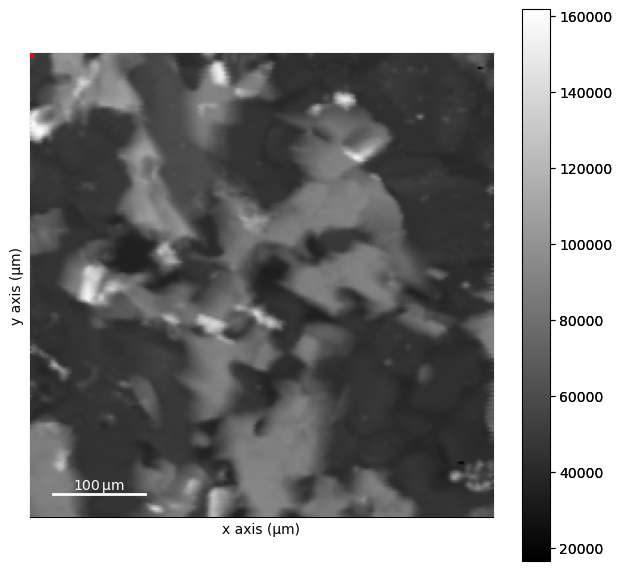

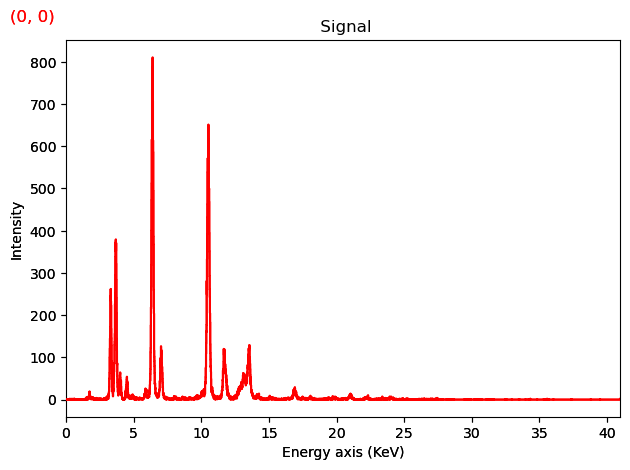

In [29]:
# plots the XRF data as an intensity counts summed map, and shows spectra
xrf_data.plot()

## Slicing signal to scanned energies <a id='link1.4'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link2.0'> **Next Section**</a>

Analysis was only carried out to 18 keV, while the last siginficant peak is to 17.71 keV. With a scaling fator of 0.1 on the channels, here we slice the energy signal using <code>.isig</code> from Hyperspy. This reduces the secondary x-rays in the region about 18 KeV from messing up dimension reduction and clustering later on.

In [30]:
xrf_data = xrf_data.isig[:1771]
print(xrf_data.axes_manager)

<Axes manager, axes: (201, 201|1771)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    201 |      0 |       0 |     2.5 |     μm 
               y |    201 |      0 |       0 |     2.5 |     μm 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |   1771 |      0 |       0 |    0.01 |    KeV 


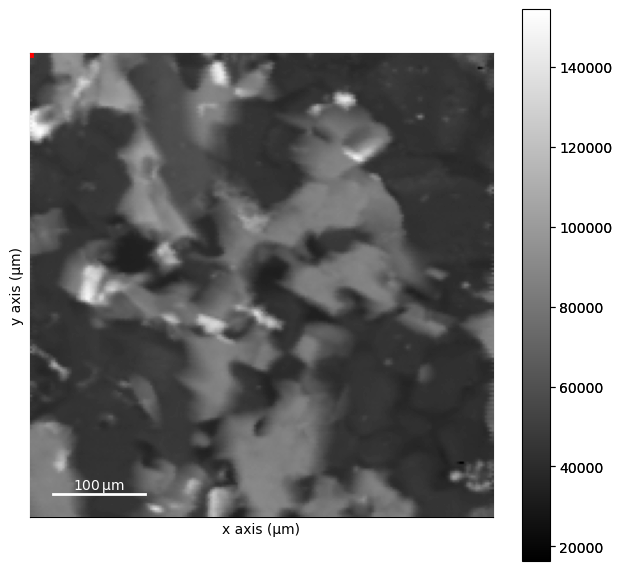

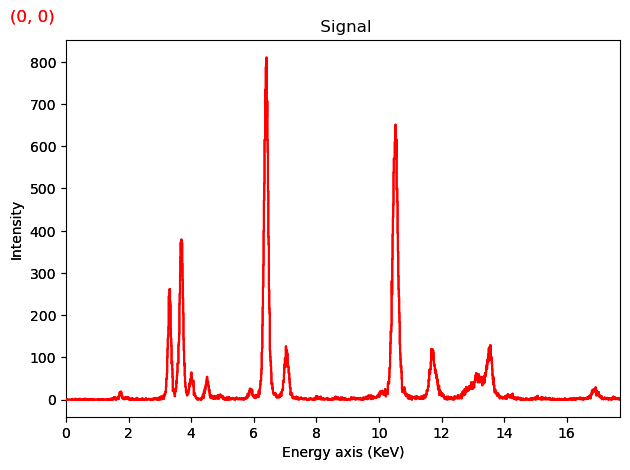

In [31]:
xrf_data.plot()

## Saving processed data <a id='link1.5'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link2.0'> **Next Section**</a>

In [32]:
xrf_data.save(data_path + filename + 'map.hspy'.format(map))

# 2.0 Region of Interest Selection<a id='link2.0'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link1.0'> **Previous Section**</a> |
<a href='#link3.0'> **Next Section**</a>


# Dimension reduction <a id='link2.1'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link3.0'> **Next Section**</a>

can start from here once the data has been pulled from the hdf5 file

In [33]:
xrf_stack = hs.load(data_path + filename + 'map.hspy', stack = True)

[########################################] | 100% Completed | 106.77 ms


In [34]:
print(xrf_stack.axes_manager)

<Axes manager, axes: (201, 201|1771)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    201 |      0 |       0 |     2.5 |     μm 
               y |    201 |      0 |       0 |     2.5 |     μm 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |   1771 |      0 |       0 |    0.01 |    KeV 


## PCA

<a href='#link0'> **Table of Contents**</a> |
<a href='#link3.0'> **Next Section**</a>



In [36]:
# define pipeline
pipeline = Pipeline([("pca", PCA(n_components=40, svd_solver='full'))])

# run decomposition using pipeline
xrf_stack.decomposition(normalize_poissonian_noise = True, algorithm = pipeline, 
                        return_info = True, output_dimension = 40)

sig_components = xrf_stack.estimate_elbow_position() + 1
print("Sig. components", sig_components)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=Pipeline(steps=[('pca', PCA(n_components=40, svd_solver='full'))])
  output_dimension=40
  centre=None
scikit-learn estimator:
Pipeline(steps=[('pca', PCA(n_components=40, svd_solver='full'))])
Sig. components 10


In [37]:
xrf_stack.decomposition(normalize_poissonian_noise = True, algorithm = pipeline, 
                        return_info = True, output_dimension = sig_components)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=Pipeline(steps=[('pca', PCA(n_components=40, svd_solver='full'))])
  output_dimension=10
  centre=None
scikit-learn estimator:
Pipeline(steps=[('pca', PCA(n_components=40, svd_solver='full'))])


Pipeline(steps=[('pca', PCA(n_components=40, svd_solver='full'))])

In [38]:
load = xrf_stack.get_decomposition_loadings()
fact = xrf_stack.get_decomposition_factors()

In [39]:
# can be moved higher up to axes management and pulled from h5 file from the run
xdim = 201
ydim = 201

In [40]:
fact, xdim ,ydim = load.data.shape

In [43]:
fact_load_vect = pd.DataFrame((load.data.reshape(fact, ydim*xdim).T), columns = ['Factor 1','Factor 2','Factor 3','Factor 4', 'Factor 5', 'Factor 6', 'Factor 7','Factor 8', 'Factor 9', 'Factor 10'])

In [44]:
fact_load_vect

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10
0,0.428822,-0.126868,-0.214531,0.004747,-0.017538,-0.025897,-0.014892,-0.006108,-0.026665,-0.025308
1,0.624336,-0.139930,-0.228732,0.004592,-0.035342,-0.044568,-0.007002,-0.010134,-0.018322,0.006191
2,0.584290,-0.114529,-0.179330,-0.000496,-0.035936,-0.043319,-0.006004,-0.023901,-0.015340,0.008312
3,0.453210,-0.113154,-0.082814,-0.013678,-0.034556,-0.046231,-0.015456,-0.015530,-0.015716,0.008240
4,0.326517,-0.161665,-0.034597,-0.006153,-0.023435,-0.054741,-0.010223,-0.002473,-0.021405,0.004868
...,...,...,...,...,...,...,...,...,...,...
40396,1.709815,0.667004,-0.325904,-0.168823,-0.008188,0.004483,-0.093761,-0.000859,-0.003617,0.009647
40397,1.848322,0.629144,-0.448542,-0.013118,0.016295,-0.036960,-0.029510,-0.011156,-0.045035,0.020095
40398,2.061228,0.466500,-0.572130,0.034665,0.017113,-0.031075,-0.005784,-0.010205,-0.017441,0.020599
40399,2.152818,0.388182,-0.692559,0.013251,0.005443,-0.040462,-0.004355,-0.004416,-0.018288,0.032106


In [45]:
fact, ydim, xdim= load.data.shape
vect = load.data.reshape(fact, ydim * xdim).transpose()
vect.shape

(40401, 10)

In [46]:
data = vect[:,:fact]
data.shape

(40401, 10)

In [47]:
sig_loadings = data

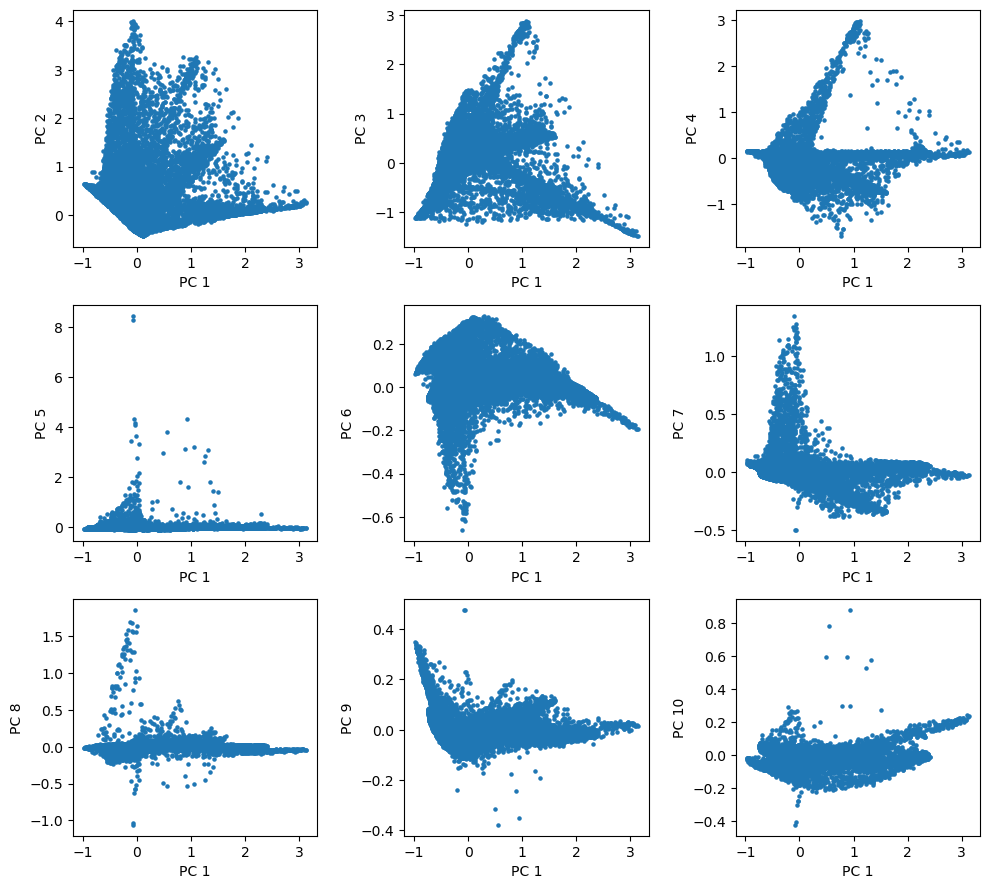

In [48]:
# number of rows and columns for subplot grid
num_pcs = sig_components - 1
num_cols = 3
if num_pcs > 0:
    num_rows = int(np.ceil(num_pcs / num_cols))
else:
    num_rows = 1
    num_cols = 1

# figure; grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))

# plots the data on subplots
for i in range(num_pcs):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].scatter(sig_loadings[:, 0], sig_loadings[:, i+1], s=5)
    axs[row, col].set_xlabel("PC 1")
    axs[row, col].set_ylabel("PC {}".format(i+2))

# removes subplots without data
for i in range(num_pcs, num_rows*num_cols):
    axs.flat[i].remove()

plt.tight_layout()

# saves figure
plt.savefig('pca.png', dpi=100)
plt.show()

## Clustering <a id='link2.2'></a>

<a href='#link0'> **Table of Contents**</a> |
<a href='#link3.0'> **Next Section**</a>

using fuzzy c-means

In [49]:
class PGK(Probabilistic, GustafsonKesselMixin):
    pass

In [121]:
n_clusts = 7
clusterer = PGK(n_clusters = n_clusts, n_init = 10)
PG = clusterer.fit(sig_loadings)

In [122]:
# Process results for visualisation
print(clusterer.memberships)
labels_ = np.argmax(clusterer.memberships, axis=1)
memberships_ = clusterer.memberships[range(len(clusterer.memberships)), labels_] 

[[1.36230231e-01 3.71386175e-02 8.63174939e-04 ... 2.48937849e-04
  7.82485527e-01 1.68047436e-04]
 [2.38934762e-02 1.49284411e-02 1.67344510e-04 ... 8.61804941e-05
  9.54264084e-01 2.80864098e-05]
 [1.11354774e-02 4.25328387e-03 6.71643042e-05 ... 3.08058580e-05
  9.82317256e-01 1.28325937e-05]
 ...
 [4.20482337e-02 1.64468121e-01 6.23642930e-04 ... 7.81855555e-03
  6.93032719e-01 5.46589261e-05]
 [1.75931486e-02 1.48829832e-01 2.76798266e-04 ... 3.06189570e-03
  7.78959140e-01 2.27302038e-05]
 [1.19225554e-02 7.43227115e-02 1.89439721e-04 ... 2.79957098e-03
  8.72237539e-01 1.54712777e-05]]


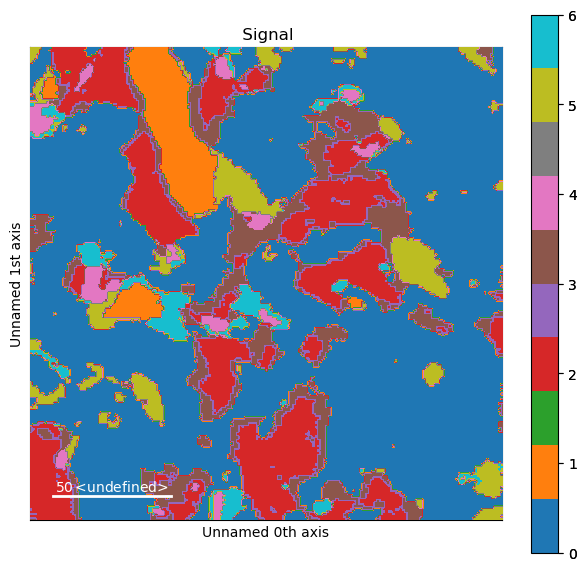

In [123]:
labels = labels_.reshape([ydim,xdim])
labels = hs.signals.Signal2D(labels)
labels.plot(cmap='tab10')

In [124]:
# Sample from matplotlib cmap:
from cmcrameri import cm
from matplotlib.colors import LinearSegmentedColormap

cluster_space=np.linspace(0,1,len(np.unique(labels)))

clust_colo=cm.batlow(cluster_space)

# Create a custom colormap using 'batlow'
batlow_cmap = LinearSegmentedColormap.from_list('batlow_cmap', clust_colo)

clust_colo

array([[0.005193, 0.098238, 0.349842, 1.      ],
       [0.078517, 0.300622, 0.382814, 1.      ],
       [0.237075, 0.428325, 0.335634, 1.      ],
       [0.511253, 0.510898, 0.193296, 1.      ],
       [0.825472, 0.577725, 0.264197, 1.      ],
       [0.991935, 0.676091, 0.619575, 1.      ],
       [0.981354, 0.800406, 0.981267, 1.      ]])

In [128]:
# Sample from matplotlib cmap:
from matplotlib import cm

cluster_space=np.linspace(0,1,len(np.unique(labels)))

clust_color=cm.tab10_r(cluster_space)

clust_color

array([[0.09019608, 0.74509804, 0.81176471, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ]])

In [129]:
mem_rs=clusterer.memberships.reshape(ydim,xdim,n_clusts).T
mem_rs.shape

(7, 201, 201)

In [130]:
mem_maps=hs.signals.Signal2D(mem_rs)
mem_maps=mem_maps.transpose((2,1))

mem_maps

<Signal2D, title: , dimensions: (7|201, 201)>

[<Axes: title={'center': ' (0,)'}>,
 <Axes: title={'center': ' (1,)'}>,
 <Axes: title={'center': ' (2,)'}>,
 <Axes: title={'center': ' (3,)'}>,
 <Axes: title={'center': ' (4,)'}>,
 <Axes: title={'center': ' (5,)'}>,
 <Axes: title={'center': ' (6,)'}>]

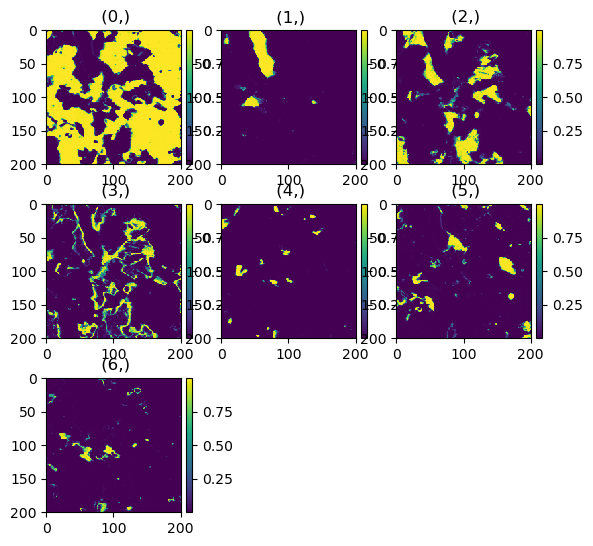

In [151]:
hs.plot.plot_images(mem_maps, cmap='viridis', per_row=3)

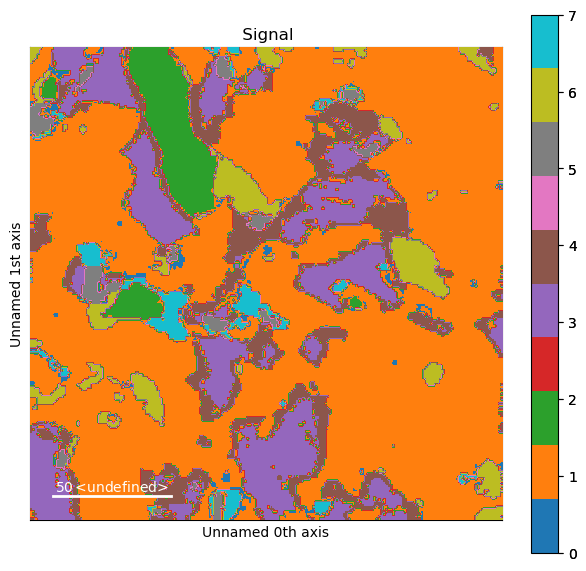

In [137]:
mem_seg=mem_maps.deepcopy()

for m in np.arange(0,len(mem_seg)):
    mem_seg.inav[m].data[mem_maps.inav[m].data>0.65]=m+1
    mem_seg.inav[m].data[mem_maps.inav[m].data<=0.35]=0

mem_seg=mem_seg.sum(0)

mem_seg.plot(cmap='tab10')

(array([ 2723., 22970.,  1702.,  5342.,  4124.,   691.,  2849.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

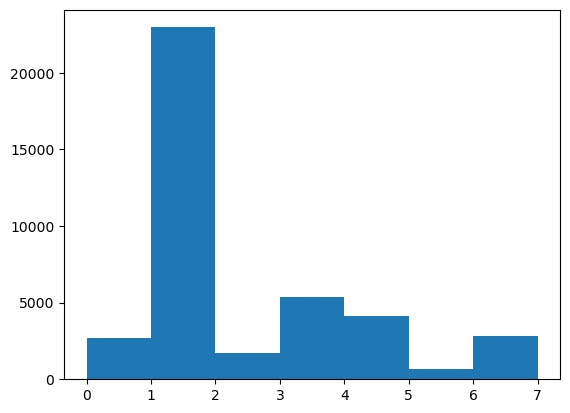

In [138]:
plt.figure()
plt.hist(mem_seg.data.reshape(xdim*ydim),bins=7)

In [139]:
# Extract elements from the 'Line' column
all_elements = regions['Line'][1:].apply(lambda x: x.split()[0])

# Convert DataFrame to a list of unique elements
elements = all_elements.unique().tolist()

print(elements)

['Si', 'Zr', 'P', 'S', 'Cl', 'K', 'Ca', 'I', 'Sc', 'Ba', 'Ti', 'Ce', 'V', 'Cr', 'Mn', 'Eu', 'Fe', 'Co', 'Ni', 'Cu', 'Re', 'Zn', 'Ge', 'Pb', 'As', 'Se', 'Br', 'Rb', 'Sr', 'Y', 'Mo']


In [146]:
# Extract elements from the 'Line' column with the format 'Element_Line'
#all_elements = regions['Line'][1:].apply(lambda x: x.split()[0] + '_' + x.split()[1])

# Make the necessary replacements in the list
#element_lines = all_elements.unique().tolist()
#element_lines = [element.replace('Zr_L', 'Zr_La').replace('I_La1', 'I_La').remove('I_Lb1', 'I_Lb').replace('Re_La1', 'Re_La').replace('Pb_La1', 'Pb_La') for element in element_lines]

# Display the modified elements list
#print(element_lines)

In [140]:
eds_local = []

for m in clusterer.memberships.T:
    with xrf_map.unfolded():
        eds_local.append(xrf_map.data[m > 0.1].mean(axis=0))

In [141]:
eds_cent = hs.signals.Signal1D(eds_local)
eds_cent.set_signal_type("EDS_SEM")
eds_cent.change_dtype('float32')
eds_cent.axes_manager[-1].name = 'Energy'
eds_cent.axes_manager['Energy'].units = 'keV'
eds_cent.axes_manager['Energy'].scale = xrf_data.axes_manager.signal_axes[0].scale

eds_cent.set_elements(elements)

In [142]:
elem_lut=hs.material.elements.as_dictionary()
ele_list=[]
for i in np.arange(0,len(elements)):
    ele_list.append([elements[i],elem_lut[elements[i]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)']])


ele_list  

[['Si', 1.7397],
 ['Zr', 15.7753],
 ['P', 2.0133],
 ['S', 2.3072],
 ['Cl', 2.6224],
 ['K', 3.3138],
 ['Ca', 3.6917],
 ['I', 28.6123],
 ['Sc', 4.0906],
 ['Ba', 32.1936],
 ['Ti', 4.5109],
 ['Ce', 34.7196],
 ['V', 4.9522],
 ['Cr', 5.4147],
 ['Mn', 5.8987],
 ['Eu', 41.5421],
 ['Fe', 6.4039],
 ['Co', 6.9303],
 ['Ni', 7.4781],
 ['Cu', 8.0478],
 ['Re', 61.1411],
 ['Zn', 8.6389],
 ['Ge', 9.8864],
 ['Pb', 74.9693],
 ['As', 10.5436],
 ['Se', 11.222],
 ['Br', 11.9238],
 ['Rb', 13.3953],
 ['Sr', 14.165],
 ['Y', 14.9584],
 ['Mo', 17.4793]]

In [143]:
print(eds_cent.axes_manager)

<Axes manager, axes: (7|1771)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |      7 |      0 |       0 |       1 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |   1771 |      0 |       0 |    0.01 |    keV 


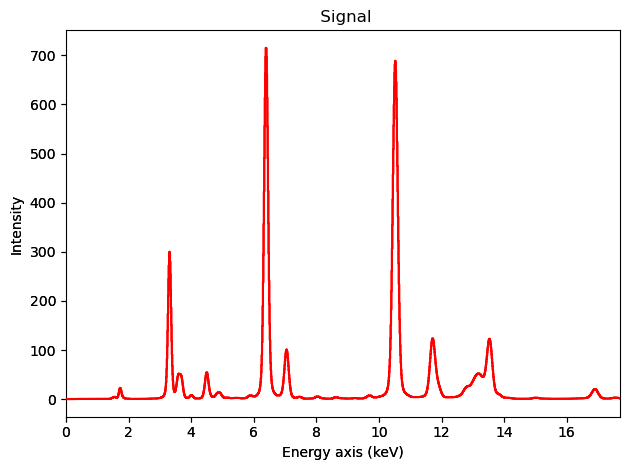

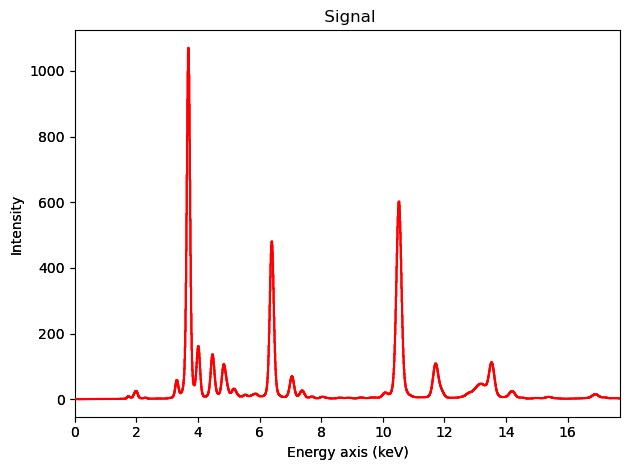

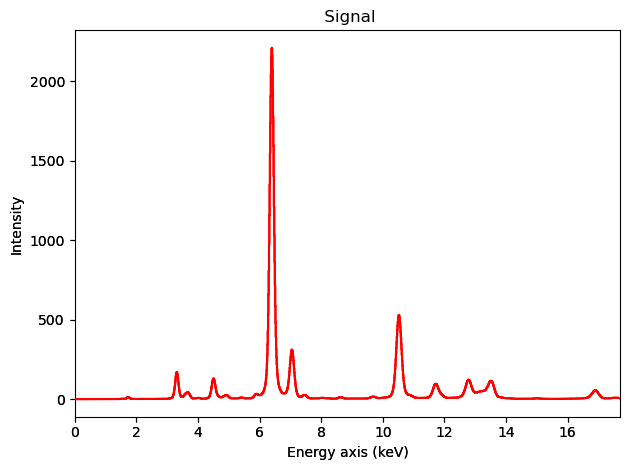

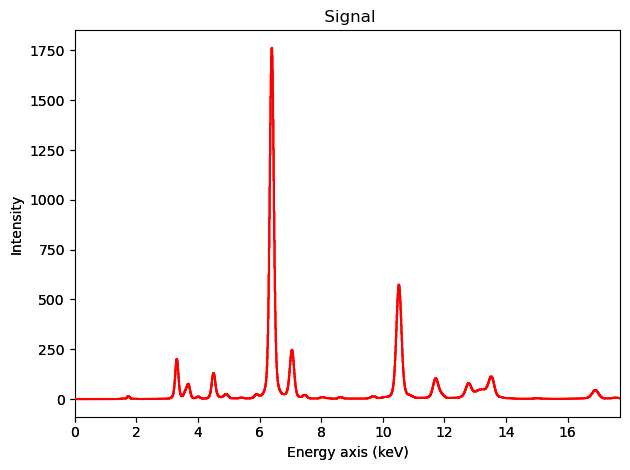

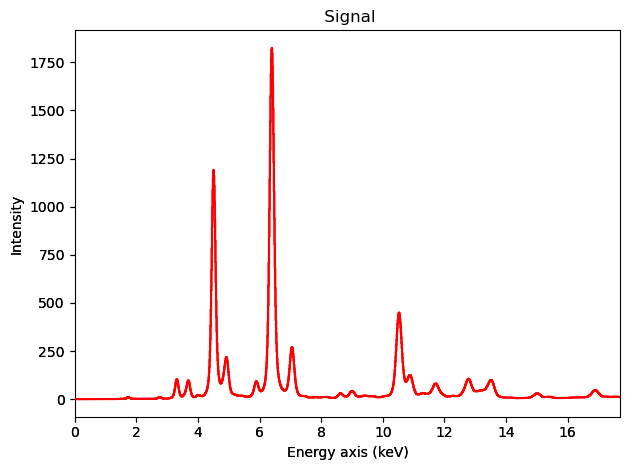

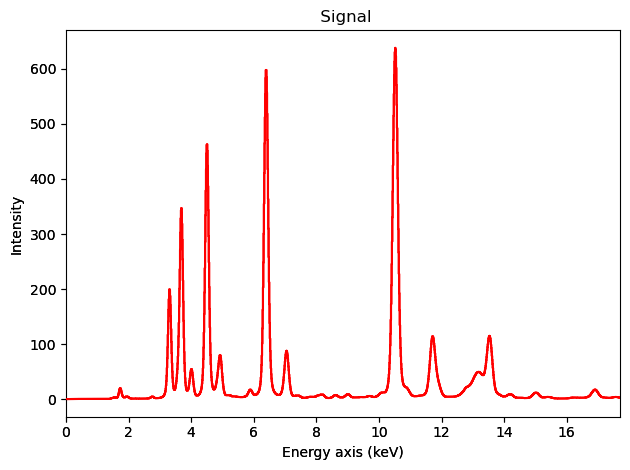

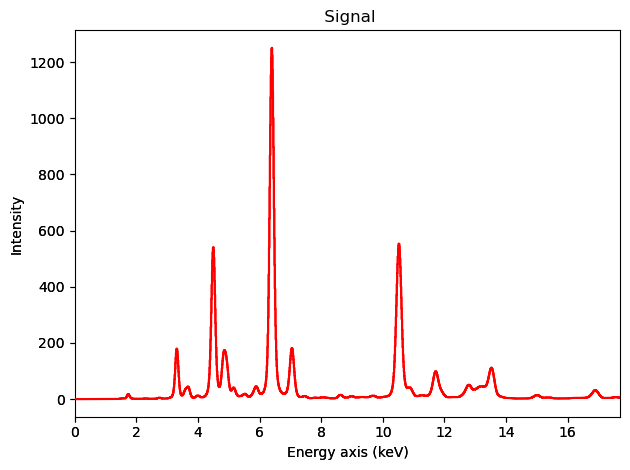

In [145]:
# Set log scale for the y-axis
eds_cent.inav[0].plot()
eds_cent.inav[1].plot()
eds_cent.inav[2].plot()
eds_cent.inav[3].plot()
eds_cent.inav[4].plot()
eds_cent.inav[5].plot()
eds_cent.inav[6].plot()

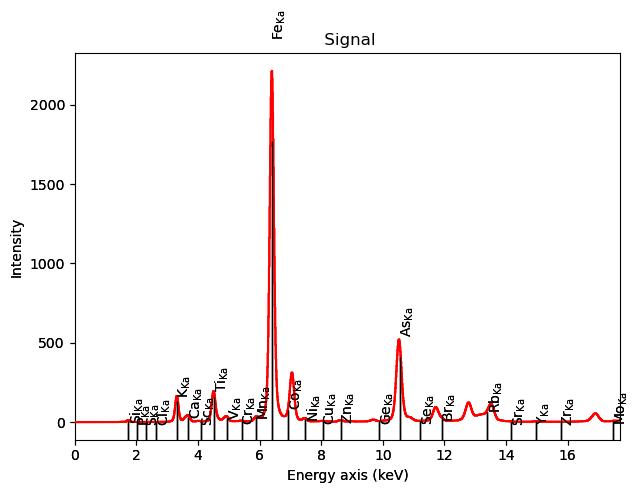

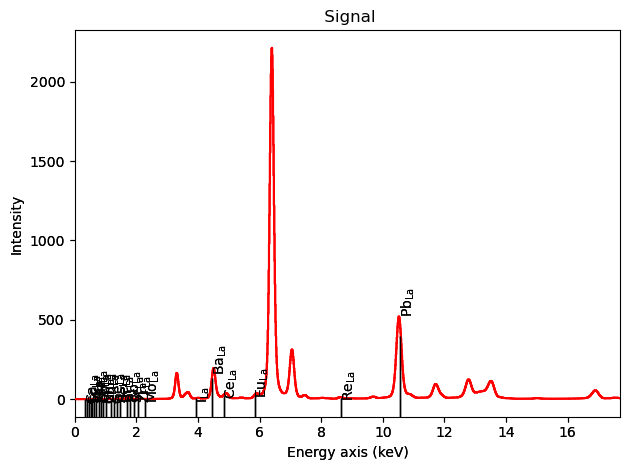

In [99]:
eds_cent.inav[0].plot(xray_lines=True, only_lines=['Ka'])
eds_cent.inav[0].plot(xray_lines=True, only_lines=['La'])

In [71]:
# Integrate the signal in the specified range
integrated = eds_cent.inav[1].integrate_in_range(signal_range=(4.39,4.62))


/Users/user/melt_map_mla/lib/python3.9/site-packages/hyperspy/misc/utils.py:1452: VisibleDeprecationWarning: The `Signal1D.integrate_in_range` method is deprecated and will be removed in v2.0. Use a `roi.SpanRoi` followed by `integrate1D` instead.
  warnings.warn(msg, VisibleDeprecationWarning)


In [73]:
eds_cent.inav[2].find_peaks1D_ohaver(maxpeakn=200)

[########################################] | 100% Completed | 102.70 ms


array([array([( 4.50658693, 21.06462241, 0.22390353),
              ( 4.91921557, 10.16412813, 0.28884914),
              ( 6.39756251, 27.04084762, 0.24843063),
              ( 7.05111714, 11.77711217, 0.27233947),
              (10.52681104, 14.07472105, 0.32040195)],
             dtype=[('position', '<f8'), ('height', '<f8'), ('width', '<f8')])],
      dtype=object)